In [1]:
# imports
import pandas as pd
import numpy as np
import nltk
import time
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

## Text Preprocessing

In [2]:
# import the excel file
df = pd.read_csv('../Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')
df.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht..."
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht..."


In [3]:
# keep only the reviews.rating and reviews.text columns
df = df[['reviews.rating', 'reviews.text']]
df.head()

,reviews.rating,reviews.text
0,3,I order 3 of them and one of the item is bad q...
1,4,Bulk is always the less expensive way to go fo...
2,5,Well they are not Duracell but for the price i...
3,5,Seem to work as well as name brand batteries a...
4,5,These batteries are very long lasting the pric...


In [4]:
# apply sentiment labels for the reviews.rating
df['sentiment'] = df['reviews.rating'].apply(lambda x: 'negative' if x <= 2 else ('neutral' if x == 3 else 'positive'))
df.head()

,reviews.rating,reviews.text,sentiment
0,3,I order 3 of them and one of the item is bad q...,neutral
1,4,Bulk is always the less expensive way to go fo...,positive
2,5,Well they are not Duracell but for the price i...,positive
3,5,Seem to work as well as name brand batteries a...,positive
4,5,These batteries are very long lasting the pric...,positive


In [5]:
# preprocess the reviews.text column

# get stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

nltk.download('punkt')
nltk.download('wordnet')

def preprocess_text(text):
    # remove numbers
    text = re.sub(r'\d+', '', text)

    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # remove capital letters
    text = text.lower()

    # tokenize the text
    tokens = word_tokenize(text)

    # remove stopwords and lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords]

    return ' '.join(tokens)

df['reviews.text'] = df['reviews.text'].apply(preprocess_text)
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mtort\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mtort\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mtort\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,reviews.rating,reviews.text,sentiment
0,3,order one item bad quality missing backup spri...,neutral
1,4,bulk always le expensive way go product like,positive
2,5,well duracell price happy,positive
3,5,seem work well name brand battery much better ...,positive
4,5,battery long lasting price great,positive


## Initial Data Visualizations

By creating a histogram of the ratings, we see that ratings tend to skew heavily towards 5 stars, suggesting to us that either people tend to leave only positive reviews or that they're failing to mark bad products low enough. This skew should be awknoledged in our model design.

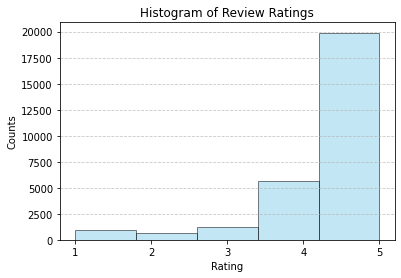

In [6]:
plt.hist(df['reviews.rating'], bins=5, color='skyblue', edgecolor='black', alpha=0.5)
plt.title('Histogram of Review Ratings')
plt.xlabel('Rating')
plt.ylabel('Counts')
plt.xticks(range(1, 6))  # Adjust x-axis ticks to match rating scale
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

From the wordclouds below we see that a majorityof the words revolve around the product with a few sentimental words. Additionally, reviews at all stars have some positive words such as "good", meaning that the model may not be able to rely on few words to give its prediction.

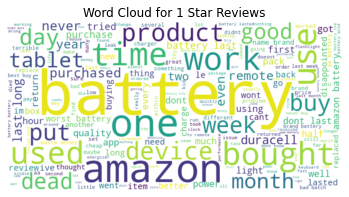

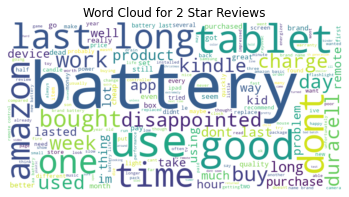

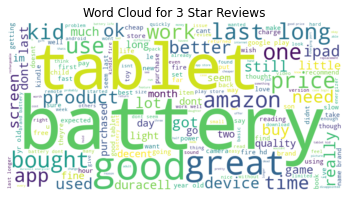

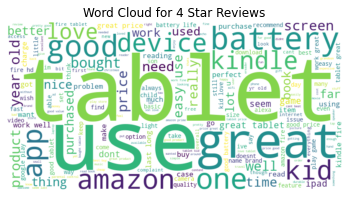

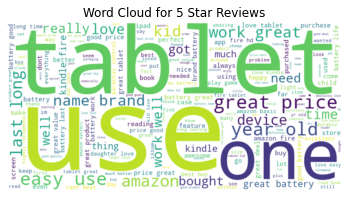

In [7]:
for rating in range(1,6):
    reviews_subset = df[df['reviews.rating'] == rating]['reviews.text']
    text = ' '.join(reviews_subset)
    
    # Create word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {rating} Star Reviews')
    plt.axis('off')
    plt.show()

## Create Word Embeddings

We will use the Word2Vec model to create word embeddings. This model will create a vector representation of each word in the corpus. This will allow us to use the word embeddings to capture the semantic meaning of the words in the reviews.

In [8]:
# load the word2vec model
word2vec_model = KeyedVectors.load_word2vec_format('../GoogleNews-vectors-negative300.bin.gz', binary=True)

In [9]:
# get the word embeddings for the reviews in the dataset
def get_sentence_embedding(sentence):
    words = sentence.split()
    embeddings = [word2vec_model[word] for word in words if word in word2vec_model]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)
    
df['embeddings'] = df['reviews.text'].apply(get_sentence_embedding)
df.head()

,reviews.rating,reviews.text,sentiment,embeddings
0,3,order one item bad quality missing backup spri...,neutral,"[-0.002293178, 0.09266444, 0.0023612976, 0.035..."
1,4,bulk always le expensive way go product like,positive,"[0.037750244, 0.11250305, 0.005601883, 0.13848..."
2,5,well duracell price happy,positive,"[0.019521078, 0.05183919, -0.11079153, 0.09977..."
3,5,seem work well name brand battery much better ...,positive,"[0.050726995, 0.0601671, -0.032755535, 0.08175..."
4,5,battery long lasting price great,positive,"[-0.0078125, 0.14204101, -0.021166991, 0.08242..."


## Model Comparison

We will compare the performance of the following models (their ability to predict the rating of a review):
- Logistic Regression
- Random Forest
- Neural Network

In [10]:
# split the dataset into training and testing sets
X = np.array(df['embeddings'].to_list())
y = df['reviews.rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# train a logistic regression model
logistic_model = LogisticRegression()

start_time = time.time()
logistic_model.fit(X_train, y_train)
training_time = time.time() - start_time

log_y_pred = logistic_model.predict(X_test)
accuracy = accuracy_score(y_test, log_y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(f'Training Time: {training_time:.2f} seconds')

Accuracy: 0.72
Training Time: 2.58 seconds


c:\Users\mtort\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:
# train a random forest model
rf_model = RandomForestClassifier()

start_time = time.time()
rf_model.fit(X_train, y_train)
training_time = time.time() - start_time

rf_y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, rf_y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(f'Training Time: {training_time:.2f} seconds')

Accuracy: 0.85
Training Time: 28.23 seconds


## Additional Metrics
Lets compare the models we've made using some addditional metics. We will use the f1, roc_auc_score, and then generate a confusion matrix for the random forest classifier.

In [13]:
#roc_auc
rf_y_pred_proba = rf_model.predict_proba(X_test)
rf_roc_auc = roc_auc_score(y_test, rf_y_pred_proba, multi_class='ovr', average ='weighted')

log_y_pred_proba = logistic_model.predict_proba(X_test)
log_roc_auc = roc_auc_score(y_test, log_y_pred_proba, multi_class='ovr', average ='weighted')

#f1 scores
rf_f1 = f1_score(y_test, rf_y_pred, average='weighted') 
log_f1 = f1_score(y_test, log_y_pred, average='weighted') 

print("Random Forest Classifier ROC_AUC score: ", rf_roc_auc)
print("Logistic Regression ROC_AUC score: ", log_roc_auc)
print("Random Forest Classifier f1 score: ", rf_f1)
print("Logistic Regression f1 score: ", log_f1)

Random Forest Classifier ROC_AUC score:  0.9112213103789132
Logistic Regression ROC_AUC score:  0.7566621383857433
Random Forest Classifier f1 score:  0.8339828595943712
Logistic Regression f1 score:  0.649486849743294


In [14]:
#confusion matrix imports
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

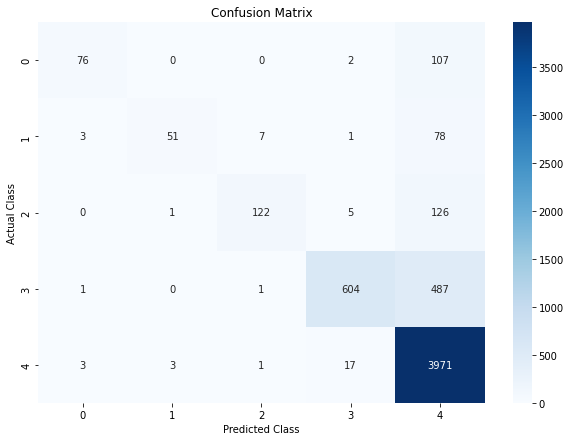

In [15]:
cm = confusion_matrix(y_test, rf_y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

## Implementing Bert Model

In this step, we will attempt the above challenge using a bert model. The following choices have been made:
- model_base: bert-base-uncased, a huggingface public bert model trained with no human input
- tokenizer: BertTokenizer, the default bert tokenizer by huggingface
- model_implementation: BertForSequenceClassification, bert implementation for classification problems
- optimizer: Adam, an advanced algorithm using first and second moments for descent (usually beats SGD)

In [16]:
# chose model (bert classifier), tokenizer (bert tokenizer), grad algo (adam), and
import torch
from transformers import BertTokenizer, BertForSequenceClassification

model_name = 'bert-base-uncased' # huggingface transformers package to download bert from pip
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=5) # bert for classification tasks on sequential data
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


device = torch.device('cuda') # forcibly use cuda if available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AssertionError: Torch not compiled with CUDA enabled

We need to tokenize our dataset, and return the following as tensors:
- tokenized_input_ids: the text with tokens encoded and stored as ints
- attention_masks: denoting which tokens are simply padding (required for bert to train)
- labels: the ratings as integers (0 - 4)

In [ ]:
# preprocess data for bert
from torch.utils.data import Dataset, DataLoader

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
max_len = 200

def encode_bert_data(df, tokenizer, max_len):
    tokenized_input_ids = []
    attention_masks = []
    labels = []
    
    for idx, row in df.iterrows():
        review_text = str(row['reviews.text'])
        rating_label = int(row['reviews.rating']) - 1 # BERT uses 0-based indexing
        encoding = tokenizer.encode_plus( # run the encoding
            review_text,
            add_special_tokens=True,
            max_length=max_len, # make all encodings to max len
            return_token_type_ids=False,
            padding='max_length', # pad if under max len
            truncation=True, # truncate if over max len
            return_attention_mask=True, # attention_mask ensures that the padding is not included in bert calculations
            return_tensors='pt' # return as tensor (always preferable)
        )

        tokenized_input_ids.append(encoding['input_ids']) # input_ids are tokenized version of inputs as ints. flatten to keep as one row
        attention_masks.append(encoding['attention_mask']) #attention masks ensure padding is not included in bert calculations
        labels.append(rating_label)

    tokenized_input_ids = torch.cat(tokenized_input_ids, dim=0) # concatinate encoding arrays vertically to torch tensors
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels, dtype=torch.long) 

    return tokenized_input_ids, attention_masks, labels

# turn data into input_ids, masks, and labels
train_input_ids, train_attention_masks, train_labels = encode_bert_data(train_data, tokenizer, max_len)
test_input_ids, test_attention_masks, test_labels = encode_bert_data(test_data, tokenizer, max_len)

print(train_input_ids.size(), train_attention_masks.size(), train_labels.size())
print(test_input_ids.size(), test_attention_masks.size(), test_labels.size())

torch.Size([22665, 200]) torch.Size([22665, 200]) torch.Size([22665])
torch.Size([5667, 200]) torch.Size([5667, 200]) torch.Size([5667])


In [ ]:
print(f"Original data example (first test row):\n{train_data.iloc[0]}")
print(f"Tokenized data example (first test row):\ninput_id: {train_input_ids[0]}\nattention_mask: {train_attention_masks[0]}\nlabel: {train_labels[0]}")
print(f"Label range: {min(train_labels)} - {max(train_labels)}")

Original data example (first test row):
reviews.rating                                                    5
reviews.text      really liked many facet tablet presence alexa ...
sentiment                                                  positive
Name: 25720, dtype: object
Tokenized data example (first test row):
input_id: tensor([  101,  2428,  4669,  2116,  2227,  2102, 13855,  3739, 24969,  3073,
         4495,  4639,  2377,  4474,  2009, 10760,  5430,  4017,  9733,  2489,
         2051,  2095,  9733,  3623,  2012, 19738,  3367,  2095,  3539,  2266,
         2008,  2015,  2326, 17612,  2015, 13855,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     

We utilize torch TensorDataset and DataLoader to split up the dataset into grouped batches. The batches help our function learn faster as it doesn't have to iterate through the entire dataset before running loss and gradient descent.

In [ ]:
# create data loaders to speed up train and test
train_dataset = torch.utils.data.TensorDataset(train_input_ids, train_attention_masks, train_labels) # combine input tensors into TensorDataset
test_dataset = torch.utils.data.TensorDataset(test_input_ids, test_attention_masks, test_labels)
train_loader = DataLoader(train_dataset, batch_size=5) # use Dataloader to accelerate testing
test_loader = DataLoader(test_dataset, batch_size=5)

We train the model for 10 epochs, running the loss and descent process after every batch. The loss used by BertClassifier is by default the cross-entropy loss, which is fine for our usecase. We try to move all the tensors to the gpu if possible to accelerate learning.

The learning process is as follows:
1. resetting grads (zero_grad)
2. computing the loss (outputs.loss)
3. running backprop on the loss (backward)
4. doing gradient descent (step)

In [ ]:
# train model
model.train()
epochs_count = 10
for epoch in range(epochs_count):
    print(f"Starting epoch {epoch}")
    for batch in train_loader: # run each batch individually
        batch_input_ids, batch_attention_masks, batch_labels = batch
        batch_input_ids = batch_input_ids.to(device) # move all tensor math to gpu
        batch_attention_masks = batch_attention_masks.to(device)
        batch_labels = batch_labels.to(device)
        
        optimizer.zero_grad() # reset optimizer grads
        outputs = model(batch_input_ids, attention_mask=batch_attention_masks, labels=batch_labels) # run bert passing in input_text, attention_mask, and target labels
        loss = outputs.loss # get loss (cross-entropy loss by default)
        loss.backward() # run backprop
        optimizer.step() # descent down the gradient
        
    print(f"Epoch {epoch} complete. Reported cross entropy loss: {loss}")

Starting epoch 0


AssertionError: Torch not compiled with CUDA enabled

We set our model to eval mode and run our batched test inputs through the model. We use logits to make the model give us one clear answer, and we keep track of the predicted and target labels. We then return the accuracy of the model as the final score.

Requires additional testing to overcome gpu issues.

In [ ]:
# test model
model.eval()
preds = []
targets = []
with torch.no_grad():
    for batch in test_loader:
        batch_input_ids, batch_attention_masks, batch_labels = batch
        batch_input_ids = batch_input_ids.to(device) # move all tensor math to gpu
        batch_attention_masks = batch_attention_masks.to(device)
        batch_labels = batch_labels.to(device)
        
        outputs = model(batch_input_ids, attention_mask=batch_attention_masks)
        _, pred = torch.max(outputs.logits, dim=1) # take logits to return most likely result
        preds.append(pred)
        targets.append(batch_labels)
    accuracy = accuracy_score(targets, preds)
    print(f'Accuracy from testing: {accuracy}')